In [2]:
# import algos and graphs
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import gzip
import random
import time
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Add parent directory to path so algorithms can be imported
sys.path.append(os.path.abspath("../algorithms"))

# Import algorithms
#from greedy import greedy_clique
#from local_search import local_search
from randomized import randomized_max_clique
from simulated_annealing import simulated_annealing_with_restarts
from bron_kerbosch import bron_kerbosch_with_pivot, bron_kerbosch_basic

print("All algorithms imported successfully.")


All algorithms imported successfully.


In [4]:
# import graphs

#import graphs
# --- Download Graph Datasets (Small + Large) ---

datasets = {
    "small": [
        # ("karate_club", "https://github.com/mlabonne/graph-datasets/blob/main/node_classification/karate-club/karate.gml"),
        # ("adjnoun_adj", "https://networkrepository.com/adjnoun-adjacency.php"),
        # ("game_of_thrones", "https://chatox.github.io/networks-science-course/practicum/data/game-of-thrones/"),
        ("marvel_heroes", "https://chatox.github.io/networks-science-course/practicum/data/marvel-hero.csv"),
        ("student_cooperation", "https://chatox.github.io/networks-science-course/practicum/data/student-cooperation.graphml"),
        # ("flavor_network", "https://chatox.github.io/networks-science-course/practicum/data/flavor-network/"),
        # ("hamsterster", "https://networkrepository.com/soc-hamsterster.php"),
        # ("ogdos_100", "<link-to-OGDOS-graph-~100nodes>"),
        # ("brock200_2", "https://turing.cs.hbg.psu.edu/txn131/graphs/brock200_2.clq"),
        # ("c-fat200-5", "https://turing.cs.hbg.psu.edu/txn131/graphs/c-fat200-5.clq"),
    ],
    # "large": [
    #     ("facebook_combined", "https://snap.stanford.edu/data/facebook_combined.txt.gz"),
        # commented because these graphs have their edges in lakhs
        # ("web-Google", "https://snap.stanford.edu/data/web-Google.txt.gz"),
        # ("amazon0601", "https://snap.stanford.edu/data/amazon0601.txt.gz"),
    # ],
}

# --- Create directories and download ---
for size, graphs in datasets.items():
    os.makedirs(f"raw_graphs/{size}", exist_ok=True)

    for name, url in graphs:
        filename = os.path.basename(url)
        path = f"raw_graphs/{size}/{filename}"

        if os.path.exists(path):
            print(f"⚡ Skipping {name}: already downloaded ({path})")
            continue

        print(f"⬇️ Downloading {name} ...")

        try:
            with requests.get(url, stream=True, verify=False, timeout=60) as r:
                r.raise_for_status()  # raise error if download fails
                with open(path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            print(f"✅ Saved: {path}\n")

        except requests.exceptions.RequestException as e:
            print(f"❌ Failed to download {name}: {e}\n")

print("🎯 All requested graph datasets processed.")


⚡ Skipping marvel_heroes: already downloaded (raw_graphs/small/marvel-hero.csv)
⚡ Skipping student_cooperation: already downloaded (raw_graphs/small/student-cooperation.graphml)
🎯 All requested graph datasets processed.


In [11]:
# --- Step 1: Input and output paths ---
input_path = "raw_graphs/small/student-cooperation.graphml"
cleaned_path = "raw_graphs/small/student-cooperation_clean.graphml"
output_path = "../data/small_graphs/student-cooperation.adj"

# --- Step 2: Clean the GraphML file ---
with open(input_path, "r", encoding="utf-8") as f:
    data = f.read()

# Replace unsupported attr types
data = (data
        .replace('attr.type="vector_float"', 'attr.type="string"')
        .replace('attr.type="vector_string"', 'attr.type="string"')
        .replace('attr.type="short"', 'attr.type="string"'))

with open(cleaned_path, "w", encoding="utf-8") as f:
    f.write(data)

print(f"✅ Cleaned GraphML saved at {cleaned_path}")

# --- Step 3: Read with NetworkX ---
print("📥 Loading cleaned GraphML ...")
G = nx.read_graphml(cleaned_path)
print(f"✅ Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.\n")

# --- Step 4: Convert to adjacency list format ---
os.makedirs(os.path.dirname(output_path), exist_ok=True)
print("🔄 Converting to adjacency list format...")

with open(output_path, "w", encoding="utf-8") as f:
    for node in sorted(G.nodes()):
        neighbors = sorted(list(G.neighbors(node)))
        f.write(f"{node}: {' '.join(neighbors)}\n")

print(f"✅ Saved adjacency list: {output_path}")
print(f"📊 Graph info: {G.number_of_nodes()} vertices, {G.number_of_edges()} edges")



✅ Cleaned GraphML saved at raw_graphs/small/student-cooperation_clean.graphml
📥 Loading cleaned GraphML ...
✅ Loaded graph with 185 nodes and 360 edges.

🔄 Converting to adjacency list format...
✅ Saved adjacency list: ../data/small_graphs/student-cooperation.adj
📊 Graph info: 185 vertices, 360 edges


In [ ]:
# Greedy

In [ ]:
# Local search

In [ ]:
# randomized

In [ ]:
# local_random

📂 Loading graph from: ../data/small_graphs/student-cooperation.adj
✅ Graph loaded: 185 vertices

🔍 Running Bron–Kerbosch algorithms...

=== Bron–Kerbosch (With Pivoting) ===
Max Clique Nodes: {'n57', 'n150', 'n148', 'n149'}
Size: 4
Runtime: 0.0008 sec

=== Bron–Kerbosch (Basic) ===
Max Clique Nodes: {'n57', 'n150', 'n148', 'n149'}
Size: 4
Runtime: 0.0005 sec



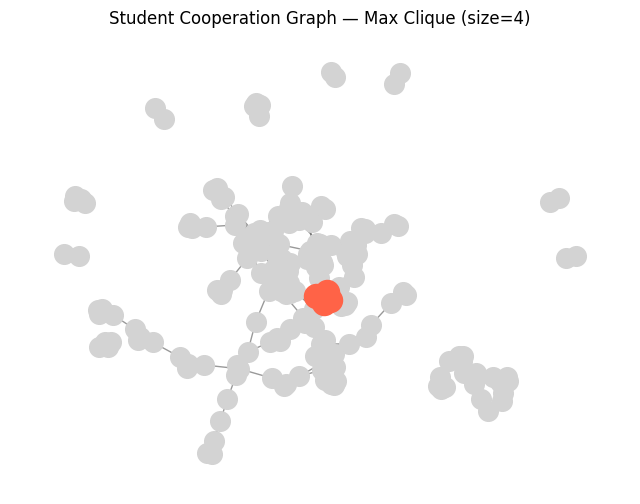

In [12]:
# bron kerbosch

# --- Step 1: Helper to load .adj file ---
def load_adj_file(path):
    """
    Loads a graph stored in adjacency list format (.adj) and
    returns a dictionary {node: set(neighbors)} suitable for Bron–Kerbosch.
    """
    adj_dict = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if ":" not in line:
                continue
            node, neighbors = line.strip().split(":", 1)
            node = node.strip()
            neighbor_set = set(neighbors.strip().split()) if neighbors.strip() else set()
            adj_dict[node] = neighbor_set
    return adj_dict


# --- Step 2: Load student cooperation graph ---
adj_path = "../data/small_graphs/student-cooperation.adj"
print(f"📂 Loading graph from: {adj_path}")
G_dict = load_adj_file(adj_path)
print(f"✅ Graph loaded: {len(G_dict)} vertices")


# --- Step 3: Run Bron–Kerbosch (pivoting & basic) ---
print("\n🔍 Running Bron–Kerbosch algorithms...\n")

# With pivot
start_pivot = time.time()
max_clique_pivot, runtime_pivot = bron_kerbosch_with_pivot(G_dict)
end_pivot = time.time()

# Basic
start_basic = time.time()
max_clique_basic, runtime_basic = bron_kerbosch_basic(G_dict)
end_basic = time.time()

# --- Step 4: Display Results ---
print("=== Bron–Kerbosch (With Pivoting) ===")
print(f"Max Clique Nodes: {max_clique_pivot}")
print(f"Size: {len(max_clique_pivot)}")
print(f"Runtime: {end_pivot - start_pivot:.4f} sec\n")

print("=== Bron–Kerbosch (Basic) ===")
print(f"Max Clique Nodes: {max_clique_basic}")
print(f"Size: {len(max_clique_basic)}")
print(f"Runtime: {end_basic - start_basic:.4f} sec\n")

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique_pivot, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique_pivot)})")
plt.axis("off")
plt.show()
